# Extraction Optimization Analysis

Now that I have completed the process of gathering data on the optimization of the feature extraction method, I would like to analyze the results of the extraction. To make an appropriate decision, I would like to answer these questions regarding the effects of different methods of feature extraction on the training of the LDA models:

1. Which method of feature extraction has the highest mean coherence score regardless of the number of topics?
2. How does the feature extraction method effect the coherence for a variety of num_topics?
3. What is the human interpretation of the best performing set of parameters, does coherence reliable indicate topical quality?

I will answer these questions by visualizing the data gathered in the optimization process, to understand how the two methods of feature extraction compare for this use case. First, however, I must Import the data and necessary libraries to conduct my analyses.

In [11]:

# Import libraries
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

# Import data
opt_df = pd.read_csv("../../../data/optimization/extraction_optimization.csv")
raw_df = pd.read_csv("../../../data/raw/song_lyrics_sampled.csv")

## Q1 - Which method of feature extraction has the highest mean coherence?

I think the best way to visualize this would be in a simple bar plot, using matplotlib. To do this, I will need to get the mean, mean score from the data for both TF-IDF observations and BoW observations. After that, I will plot the bars using these calculations, show and save.

First, calculate mean:

In [12]:
# Separate tfidf and bow observations:
tfidf_df = opt_df[opt_df['method'] == 'tfidf']
bow_df = opt_df[opt_df["method"] == "bow"]

# Calculate mean "mean score" variables
mean_tfidf = tfidf_df["mean score"].mean()
mean_bow = bow_df["mean score"].mean()

# Print
print("tfidf", mean_tfidf)
print("bow", mean_bow)

tfidf 0.4717237052293659
bow 0.39722378730558505


Now, I simply have to plot the values. To do this, I will first put the data into an interpretable format for matplotlib, before conducting the actual plotting. After this, I will display the plot, save it as and image and close:

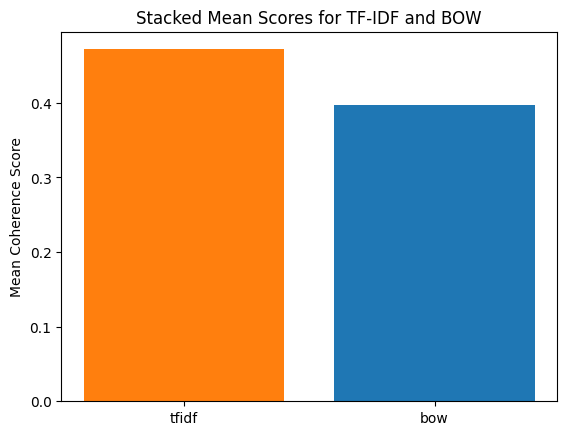

In [13]:
# Make data interpretable
methods = ['Method']
scores = {'tfidf': mean_tfidf, 'bow': mean_bow}

# Define colors for plot
colors = ["tab:orange", "tab:blue"]

# Plot bars
plt.bar(scores.keys(), scores.values(), color=colors)

# Adding labels and title
plt.ylabel('Mean Coherence Score')
plt.title('Mean Coherence Scores for TF-IDF and BOW LDA Models')

# Show, save, close
plt.show()
plt.savefig("../../../data/analysis/optimization/extraction/mean_coherence.png")
plt.close()

From this, it's obvious that TF-IDF extraction on average surpasses BoW extraction, as far as Coherence goes. However, I still think it is important to check out how they both react on different num_topics values.

## Q2 - How does the feature extraction method effect the coherence for a variety of num_topics?

Here, I will visualize the mean scores of both methods of feature extraction across the `num_topics` variable. This will help me to understand the relationship between the method of extraction and the number of topics used to train the model, with the number of topics used to train each genres model likely to differ.

To do this, I will do a line plot to visualize the mean coherence scores across the three `num_topics` values. First, again, I need to prepare the data:

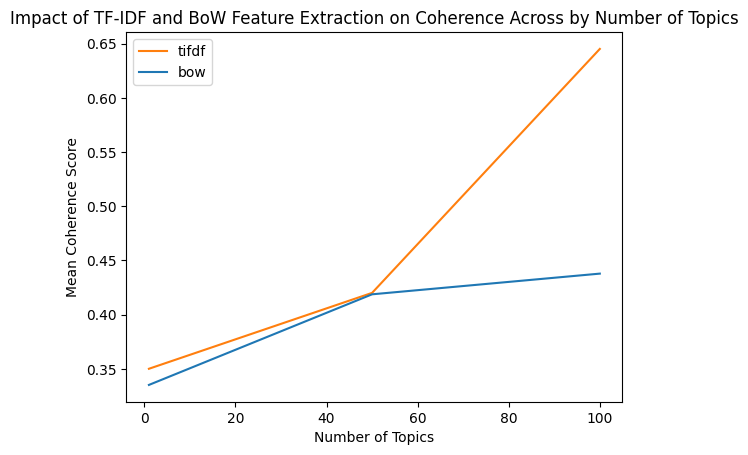

In [14]:
# Separate df
tfidf_df = opt_df[opt_df['method'] == 'tfidf']
bow_df = opt_df[opt_df['method'] == 'bow']

plt.plot(tfidf_df["num_topics"], tfidf_df["mean score"], color="tab:orange")
plt.plot(bow_df["num_topics"], bow_df["mean score"], color="tab:blue")

plt.ylabel("Mean Coherence Score")
plt.xlabel("Number of Topics")
plt.title("Impact of TF-IDF and BoW Feature Extraction on Coherence Across Number of Topics")
plt.legend(["tifdf", "bow"])

plt.show()
plt.savefig("../../../data/analysis/optimization/extraction/impact_of_num_topics_on_tfidf_and_bow_coherence")
plt.close()

This plot appears to show that TF-IDF vectorization for the use case of lyrics has a coherence score the increases far more rapidly than feature extraction using Bag-of-Words. This seems like it is indicative of the Bag-of-Words model being too noisy for my use case, meaning it may take a longer time to converge, or simply that TF-IDF performs better.

All this aside, c_v coherence is (albeit considerably reliable) metric for determining human interpretability of topics in topic modelling. However, to get a true understanding of their effects, I think it would be good to visualize the topics themselves.

## Q3 - What is the human interpretation of the best performing set of parameters, does coherence reliably indicate topical quality?

Now I would like to see how each of the best num_topics for coherence compare when actually looking at the topics themselves. While coherence is considered reliable, it is important to check the actual output of the trained topics to understand what effect these actually have on the quality of the topics. To visualize this I will use wordclouds. But first, I must train two LDA models to generate topics based on a random sample of my data.

In [51]:
# Import cleaner & cleaning data
from src.clean.lyrics_cleaner_class import LyricsCleaner
from src.utils import read_json_mapping, txt_to_set
stop_words = txt_to_set("../../../data/vocab/stopwords.txt")
contractions = read_json_mapping("../../../data/vocab/contractions.json")
dropped_gs = read_json_mapping("../../../data/vocab/dropped_gs.json")

# Import dataset
data = pd.read_csv("../../../data/raw/song_lyrics_sampled.csv")


cleaner = LyricsCleaner(list(stop_words), contractions, dropped_gs, remove_adlibs=False, remove_min_len_adlibs=False)
lyrics, texts = cleaner.clean_lyrics(data.lyrics)

Now to extract the features and train the models:

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

num_topics = 100

# Create bow dictionary
bow_dct = Dictionary(texts)

# Create bow corpus
bow_corpus = [bow_dct.doc2bow(doc) for doc in texts]

# Train bow model
bow_model = LdaModel(corpus=bow_corpus, passes=10, id2word=bow_dct, num_topics=num_topics, minimum_probability=0.0000000000000001)

# Create dtm
vec = TfidfVectorizer(lowercase=False)
dtm = vec.fit_transform(lyrics)
vocab = vec.vocabulary_.items()

# Create TF-IDF corpus
tfidf_corpus = Sparse2Corpus(dtm)

# Create TF-IDF Dictionary
tfidf_dct = Dictionary.from_corpus(
    tfidf_corpus, id2word={v: k for k, v in vocab})

# Train tf-idf model
tfidf_model = LdaModel(corpus=tfidf_corpus, passes=10, id2word=tfidf_dct, num_topics=num_topics, minimum_probability=0.0000000000000001)


Finally, it's time to create the wordclouds.

[(83, [('obladi', 0.0073164226), ('ideal', 0.0073149335), ('kuyabanda', 0.006637374), ('meeeeeeeeeeeeeeattah', 0.006445177), ('lelet', 0.006287089), ('marylate', 0.006118046), ('mizeel', 0.006089806), ('insania', 0.006028409), ('inquires', 0.005815741), ('misanthropy', 0.005774361), ('investigatin', 0.0057336073), ('ithustle', 0.0056925546), ('fododo', 0.005506467), ('kroe', 0.0054665403), ('klingons', 0.0054532187), ('jizz', 0.0051347343), ('gasoline', 0.005084131), ('killsuh', 0.0050513726), ('heywood', 0.0050290786), ('doovers', 0.0050141234), ('maurys', 0.0048992475), ('líbrase', 0.0048639826), ('kayo', 0.004862823), ('jetson', 0.00485226), ('mine', 0.0048317937), ('iowa', 0.004761397), ('pinebox', 0.004733841), ('letcha', 0.004664902), ('lobotomy', 0.0046439017), ('killem', 0.0046224985), ('prophetess', 0.004537504), ('insamusicprobe', 0.0045223017), ('mildy', 0.0045112506), ('halleluhalleluhallelujah', 0.004506282), ('racksonracksonracks', 0.004391895), ('jm', 0.004375152), ('fri

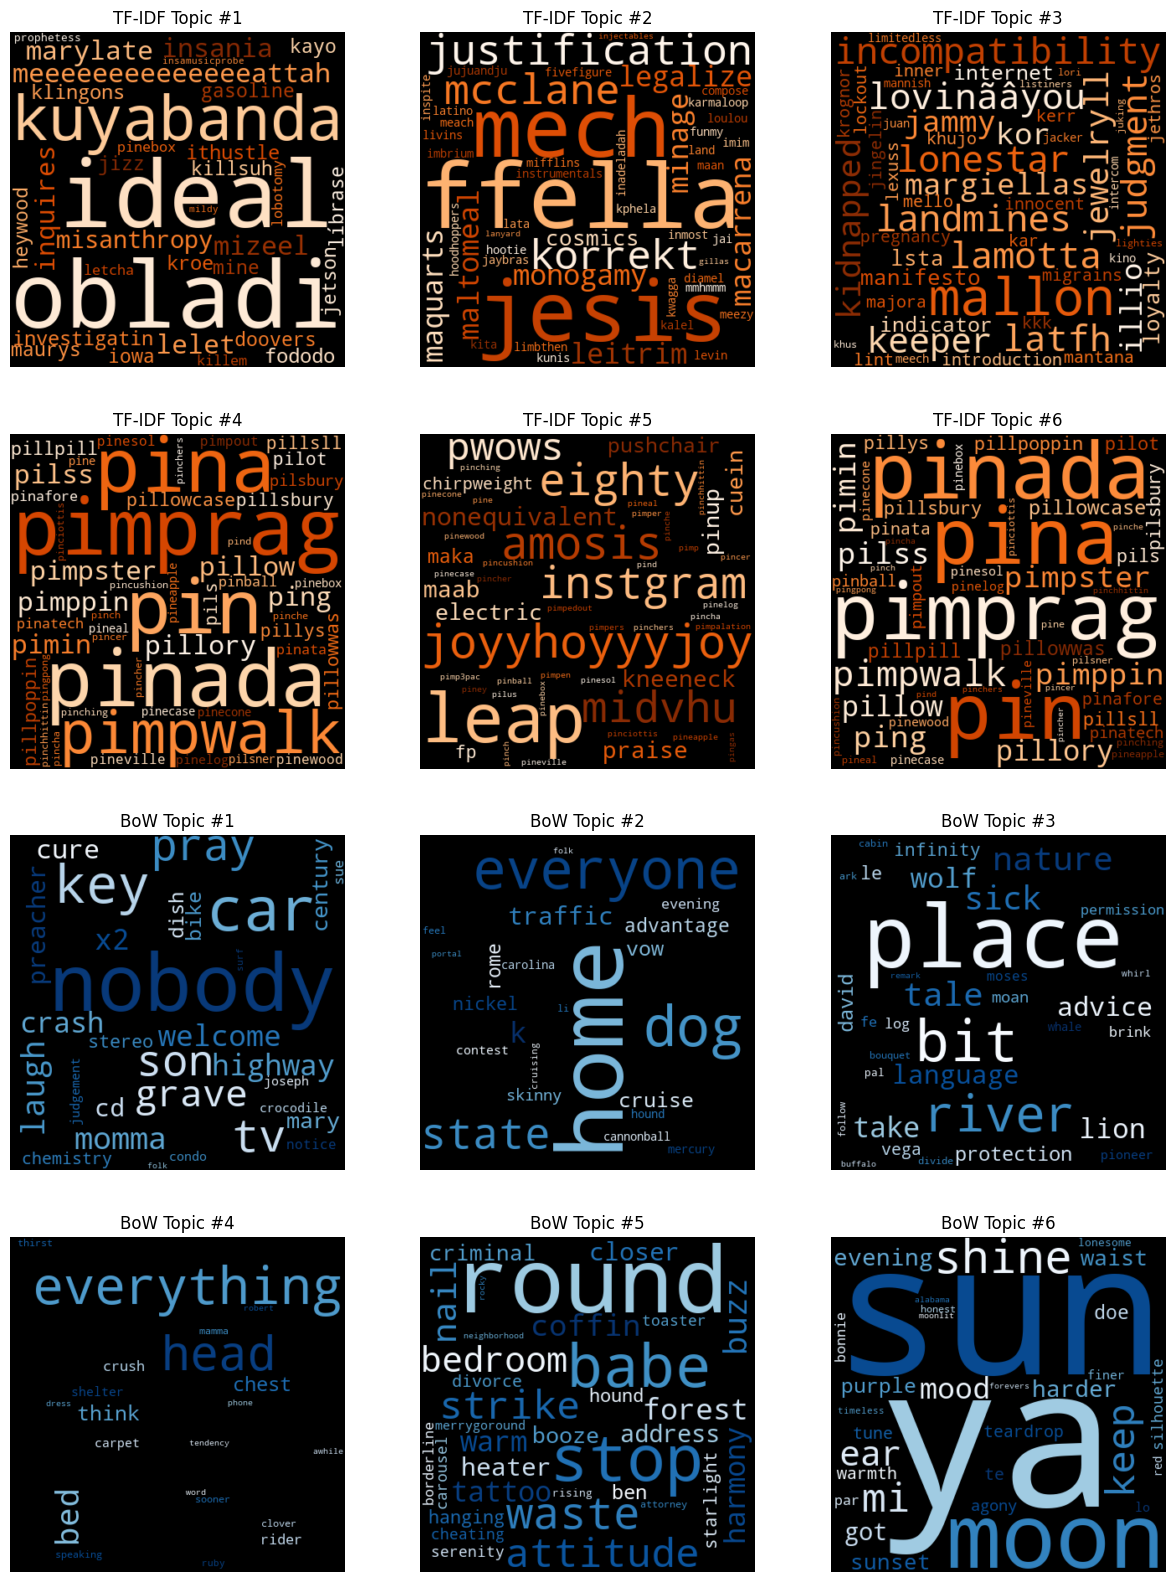

     model  topic                  word     frequency
0    tfidf      1                obladi  7.316423e-03
1    tfidf      1                 ideal  7.314933e-03
2    tfidf      1             kuyabanda  6.637374e-03
3    tfidf      1  meeeeeeeeeeeeeeattah  6.445177e-03
4    tfidf      1                 lelet  6.287089e-03
..     ...    ...                   ...           ...
595    bow      6               funcary  3.758941e-07
596    bow      6            favoritism  3.758941e-07
597    bow      6              exigency  3.758941e-07
598    bow      6              purpdogg  3.758941e-07
599    bow      6               eficacy  3.758941e-07

[600 rows x 4 columns]


<Figure size 640x480 with 0 Axes>

In [56]:

import math

tfidf_topics = tfidf_model.show_topics(num_topics=6, num_words=50, formatted=False)
bow_topics = bow_model.show_topics(num_topics=6, num_words=50, formatted=False)

num_cols = 3
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()
print(tfidf_topics)
print(bow_topics)

topics = []

for i, topic in enumerate(tfidf_topics):
    dict_words = dict(topic[1])

    wordcloud = WordCloud(width=400, height=400, 
                          background_color='black',
                          colormap="Oranges", 
                          min_font_size=10).generate_from_frequencies(dict_words)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f"TF-IDF Topic #{i+1}")
    
    topics.extend(
        [{'model': 'tfidf', 'topic': i+1, 'word': word, "frequency": freq} for word, freq in topic[1]]
    )

for i, topic in enumerate(bow_topics):
    dict_words = dict(topic[1])
    wordcloud = WordCloud(width=400, height=400, 
                          background_color='black', 
                          colormap="Blues",
                          min_font_size=10).generate_from_frequencies(dict_words)
    
    axes[i+6].imshow(wordcloud, interpolation='bilinear')
    axes[i+6].axis("off")
    axes[i+6].set_title(f"BoW Topic #{i+1}")
    topics.extend(
        [{'model': 'bow', 'topic': i+1, 'word': word, "frequency": freq} for word, freq in topic[1]]
    )

plt.show()
plt.savefig("../../../data/analysis/optimization/extraction/bow_v_tf-idf_wordclouds.png")

topic_df = pd.DataFrame(topics)
topic_df.to_csv("../../../data/analysis/optimization/extraction/bow_v_tfidf_topic_terms.csv")
print(topic_df)

## Summary

After analyzing the extraction method to train the LDA models on, it is clear that TF-IDF has the best measure coherence score when it comes to training the model. The model appears to perform better, both in terms of coherence mapped across the increasing number of topics, but also in terms of average coherence. This may lead one to believe that TF-IDF is the best choice to train the LDA models on.

However, the most important attribute of the process - the output of the models themselves, appears to show major differences in the output, with TF-IDF seeming to have less human interpretability (at least as far as I am concerned). It appears that LDA models trained with TF-IDF corpora, for the use case of lyrics, have an inclination of assigning topics of words that seem to typically start with the same character. Although this might be more useful for use cases such as exploration into rhyming vocabulary, or for some explorative lyrical tool, it does not provide any sense of a consistent meaning to the words (in other words, topics). I can also see that the TF-IDF model shows more 'noise' words, such as 'mmhmmm' which appear to have no inherent meaning on their own.

To conclude, I will use Bag-of-Words as the provisional form of feature extraction for the remainder of this process, in order to better understand the recurring themes in song lyrics across genres.